# Building Deep Neural Network

<img src="images/final-outline.png" style="width:800px;height:500px;">

## 1 - Packages

- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from skimage.transform import resize
from dnn_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Dataset

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [4]:
m_train = train_y.shape[1]
m_test = test_y.shape[1]
num_px = train_x_orig.shape[1]

print("{}{}".format("train_x_orig shape: ", train_x_orig.shape))
print("{}{}".format("train_y shape: ", train_y.shape))
print("{}{}".format("test_x_orig shape: ", test_x_orig.shape))
print("{}{}".format("test_y shape: ", test_y.shape))

print ('\n' + "-------------------------------------------------------" + '\n')

print("{}{}".format("Number of training examples: ", m_train))
print("{}{}".format("Number of test examples: ", m_test))

print ('\n' + "-------------------------------------------------------" + '\n')

print("{}{}".format("Height/Width of each image: ", num_px))
print("{0}({1}, {1}, {2})".format("Each image is of size: ", num_px, 3))

train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)

-------------------------------------------------------

Number of training examples: 209
Number of test examples: 50

-------------------------------------------------------

Height/Width of each image: 64
Each image is of size: (64, 64, 3)


y = [1], it's a 'cat' picture


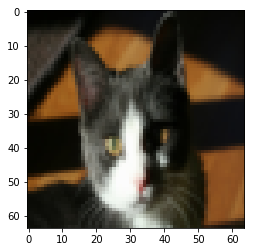

In [5]:
# Example of a picture
index = 19
plt.imshow(train_x_orig[index])
print("y = {0}, it's a '{1}' picture".format(train_y[:, index],
                                          classes[np.squeeze(train_y[:, index])].decode("utf-8")))

### 2.1 - reshape and standardize the images

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print("{}{}".format("train_x shape: ", train_x.shape))
print("{}{}".format("test_x shape: ", test_x.shape))

train_x shape: (12288, 209)
test_x shape: (12288, 50)


## 3- Helper Functions

### 3.1 -  Sigmoid Activation

In [7]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    A = 1/(1 + np.exp(-Z))
    cache = Z
    return A, cache

### 3.2 - ReLU Activation

In [8]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """    
    A = np.maximum(0, Z)    
    cache = Z 
    return A, cache

### 3.3 - Sigmoid Backward

- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit.
$$
\begin{aligned}
    &a = g(z)=\frac{1}{1+e^{-z}} \\
    \Rightarrow &\frac{da}{dz} = g'(z)=\frac{e^{-z}}{(1+e^{-z})^2}=a(1-a)\\
    \Rightarrow & \frac{\partial J}{\partial z}=\frac{\partial J}{\partial a}\frac{da}{dz}=\frac{\partial J}{\partial a} g'(z)
\end{aligned}
$$



- **`relu_backward`**: Implements the backward propagation for RELU unit.

$$
\begin{aligned}
    &a = g(z)=\max(0, z)\\
    \Rightarrow &\frac{da}{dz} =g'(z)=\mathbb{1}(z> 0)\\
    \Rightarrow & \frac{\partial J}{\partial z}=\frac{\partial J}{\partial a}\frac{da}{dz}=\frac{\partial J}{\partial a} g'(z)
\end{aligned}
$$



If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$.

In [9]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """    
    Z = cache   
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

### 3.4 - ReLU Backward

In [10]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """    
    Z = cache
    dZ = np.copy(dA)     
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ

## 4 - Initialization

In [11]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))   
    return parameters

## 5 - Forward propagation module

### 5.1 - Linear Forward 

In [12]:
def linear_forward(A_prev, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)    
    return Z, linear_cache

### 5.2 - Linear-Activation Forward

In [13]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    linear_activation_cache = (linear_cache, activation_cache)
    return A, linear_activation_cache

### 5.3 -  L-Layer Model 

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">

In [14]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
            
    return AL, caches

## 6- Cost function

**Cross-entropy cost**

$$J = -\frac{1}{m} \sum_{i = 1}^{m} \left[y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)\right]$$

In [15]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    cost = - np.mean(Y * np.log(AL) + (1-Y) * np.log(1 - AL))
    return np.squeeze(cost)

## 7 - Backward propagation module

### 7.1 - Linear backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial J }{\partial Z^{[l]}}$. 

You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

$$ dW^{[l]} = \frac{\partial J }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial J }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial J }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$


In [16]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T)/m
    db = np.mean(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

### 7.2 - Linear-Activation backward

In [17]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### 7.3 - L-Model Backward 

<img src="images/mn_backward.png" style="width:450px;height:300px;">

** Initializing backpropagation**:

- **Output**: $A^{[L]} = \sigma(Z^{[L]})$.

- **Cross-entropy cost**

$$
\begin{aligned}
J &= -\frac{1}{m}\sum_{i = 1}^{m} \left[y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)\right]\\
\Rightarrow \frac{\partial J}{\partial a^{[L] (i)}}& =-\frac{y^{(i)}}{a^{[L] (i)}}+\frac{1-y^{(i)}}{1-a^{[L] (i)}}
\end{aligned}
$$

- **Python code**:
```python
dAL = - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL) # derivative of cost with respect to AL
```

In [18]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL)
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    for l in range(L-1, 0, -1):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads["db" + str(l)] = linear_activation_backward(grads["dA" + str(l)], current_cache, "relu")
    return grads

### 7.4 - Update Parameters



$$ 
\begin{aligned}
W^{[l]} &= W^{[l]} - \alpha \text{ } dW^{[l]}\\ 
b^{[l]} &= b^{[l]} - \alpha \text{ } db^{[l]} 
\end{aligned}
$$

In [19]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]
    return parameters

## 8 - L-layer Neural Network


```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [20]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [21]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []  # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


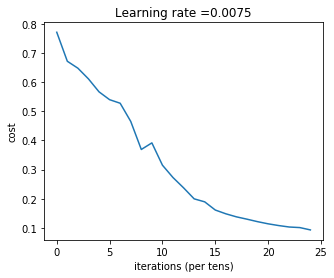

In [22]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

## 9 - Prediction Accuracy

In [23]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    pred = probas > 0.5
    print("Accuracy: {}".format(np.mean(pred == y)))
    return pred

In [24]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143541


In [25]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


## 10 - Result Analysis

### 10.1 - Mislabeled Images

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

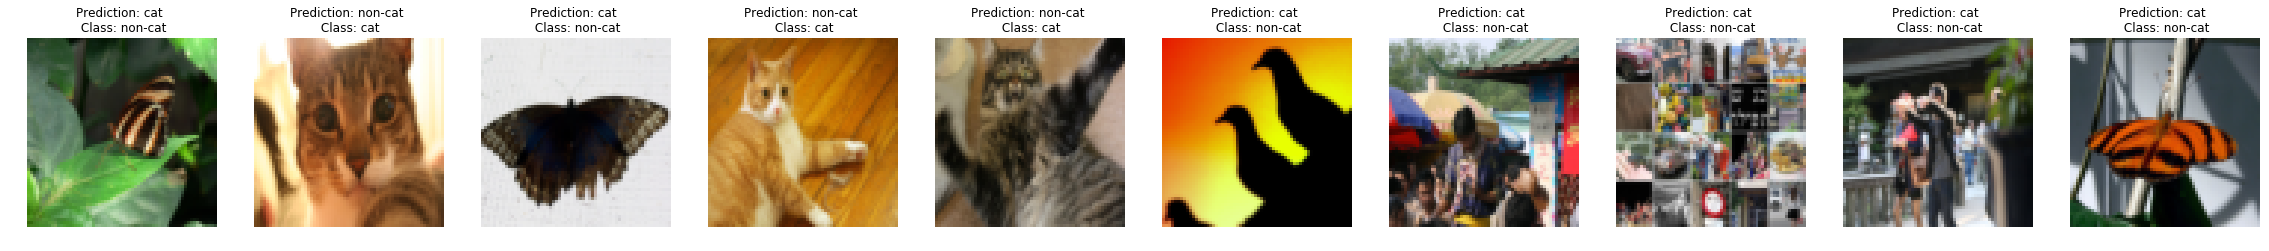

In [26]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

### 10.2 - Test with your own image

Accuracy: 1.0
y = False, predicts a 'non-cat' picture


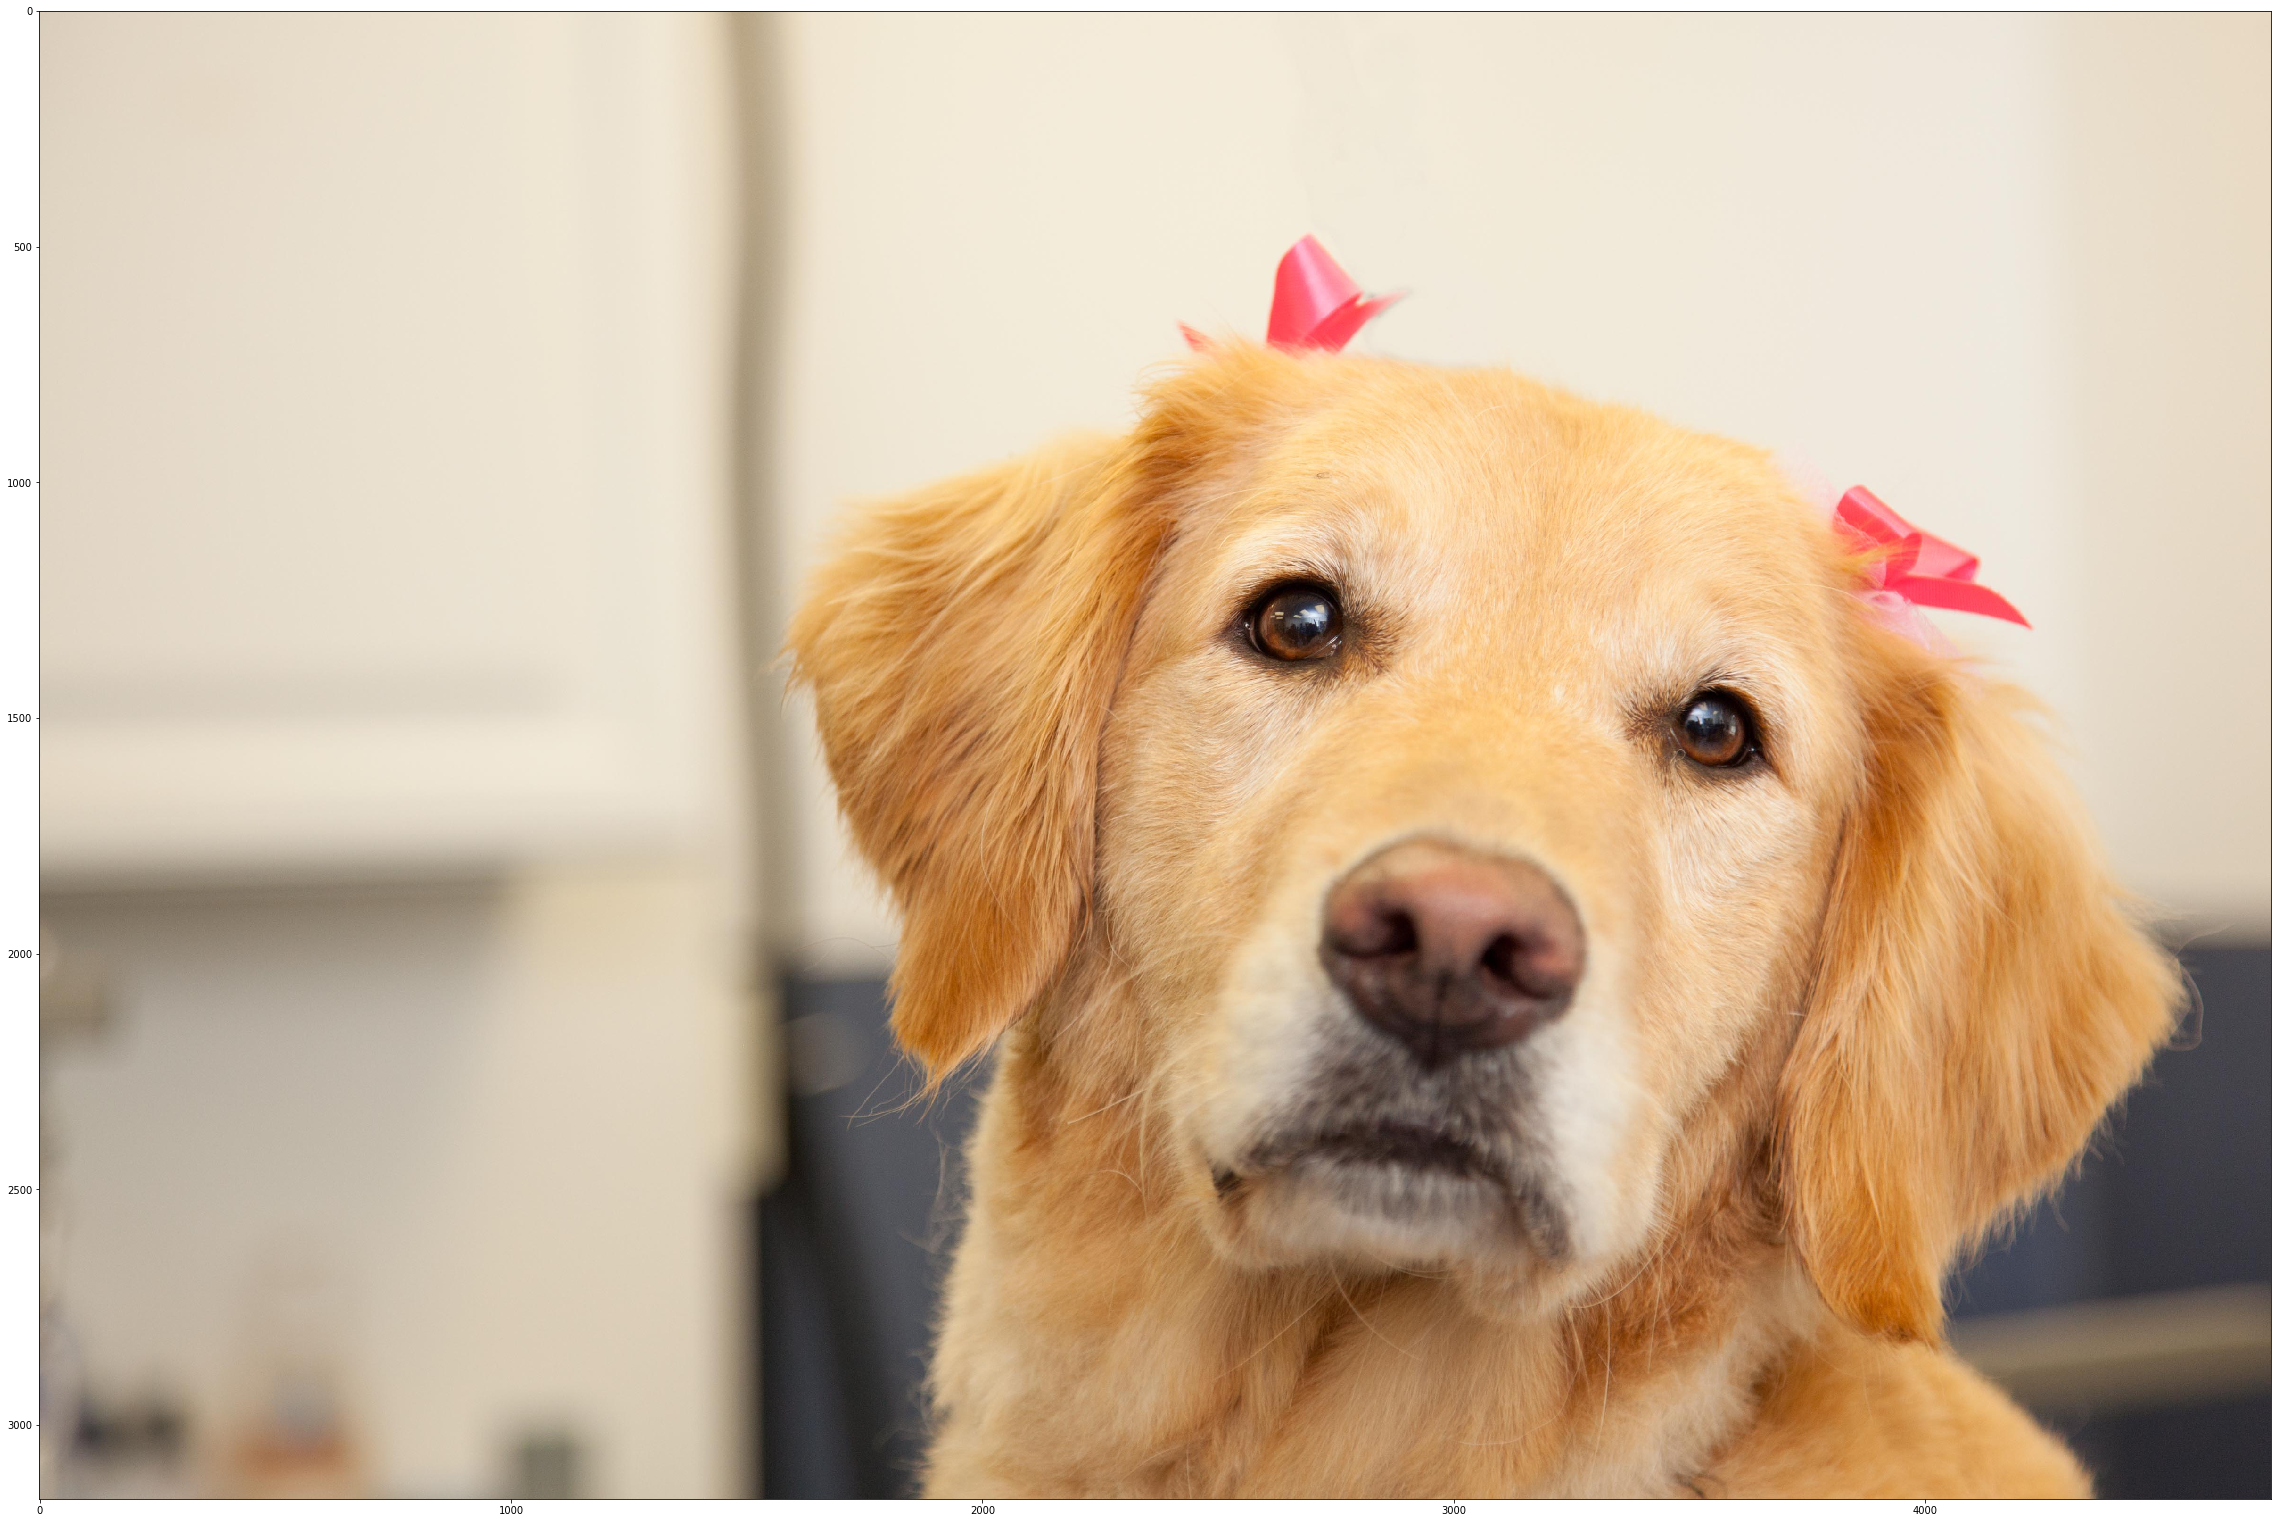

In [27]:
my_image = "Dog-grooming.jpg" # change this to the name of your image file 
my_label_y = [0] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = resize(image, 
                  output_shape = (num_px, num_px),
                  mode = 'constant').reshape((1, num_px * num_px * 3)).T
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
mylabel = np.squeeze(my_predicted_image)
myclass = classes[int(np.squeeze(my_predicted_image)),].decode("utf-8")
print("y = {0}, predicts a '{1}' picture".format(mylabel, myclass))